# Simdata - Analysis #
This notebook analyses the summary of the files created by the simdata-pipeline

In [65]:
from pathlib import Path
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [66]:
def get_dataset(tsv):
    """
    Args:
        tsv: The path to the tsv (Summary) of the analysis
    
    Returns:
        the dataset - but restructured with some additional information
    """
    print(f"process file {tsv}", end='\r')
    dataset_raw = pd.read_csv(tsv, sep="\t",dtype={"Krakenfilter":str, "Dataset":str, "Kmer":str})
    
    dataset_raw["Correct"]= dataset_raw["Family"]==dataset_raw["Assigned_Fam"]
    dataset_raw["Aligned_Correct"]= dataset_raw.apply(lambda x: (x["Correct"]+ x["Aligned"]) == 2, axis=1) 
    dataset_raw["Deduped_Correct"]= dataset_raw.apply(lambda x: (x["Correct"]+ x["Deduped"]) == 2, axis=1) 
    dataset_raw["Bedfiltered_Correct"]= dataset_raw.apply(lambda x: (x["Correct"] + x["Bedfiltered"]) == 2, axis=1) 
    dataset_raw=dataset_raw[dataset_raw.Assigned_Fam != "None"]
    
    dataset = dataset_raw.groupby(["Dataset","Regime", "Kmer", "Krakenfilter", "Assigned_Fam"],as_index=False).sum()
    
    """Get for each Kmer and Krakenfilter a dict of families and the proportion of it
    filterdict_dict = {Kmer16:{Kraken00:{Hominidae: {Assigned: 0.1, Deduped:0.015} ...},...},...}
    """
    filterdict_dict = {}
    for kmer in set(dataset["Kmer"]):
        krakdict = defaultdict(dict)
        for kraken in set(dataset["Krakenfilter"]):
            props = {}
            subset1 = dataset[(dataset.Kmer == kmer)&(dataset.Krakenfilter == kraken)].groupby(
                'Assigned_Fam', as_index=False).sum()
            subset1['Extracted_Ratio'] = subset1['Extracted']/sum(subset1['Extracted'])
            subset1['Aligned_Ratio'] = subset1['Aligned']/sum(subset1['Aligned'])
            subset1['Deduped_Ratio'] = subset1['Deduped']/sum(subset1['Deduped'])
            subset1['Bedfiltered_Ratio'] = subset1['Bedfiltered']/sum(subset1['Bedfiltered'])
            sub_dict=subset1.to_dict()
            
            for n in range(len(sub_dict["Assigned_Fam"])):
                props2 = {}
                props2["Assigned"] = sub_dict["Extracted_Ratio"][n]
                props2["Aligned"] = sub_dict["Aligned_Ratio"][n]
                props2["Deduped"] = sub_dict["Deduped_Ratio"][n]
                props2["Bedfiltered"] = sub_dict["Bedfiltered_Ratio"][n]
                props[sub_dict["Assigned_Fam"][n]] = props2
            
            krakdict[kraken]=props
        filterdict_dict[kmer]=krakdict
        
    dataset["Fam_prop_extr"] = dataset.apply(lambda x: filterdict_dict[x[2]][x[3]][x[4]]["Assigned"], axis=1);
    dataset["Fam_prop_align"] = dataset.apply(lambda x: filterdict_dict[x[2]][x[3]][x[4]]["Aligned"], axis=1);
    dataset["Fam_prop_deduped"] = dataset.apply(lambda x: filterdict_dict[x[2]][x[3]][x[4]]["Deduped"], axis=1);
    dataset["Fam_prop_bed"] = dataset.apply(lambda x: filterdict_dict[x[2]][x[3]][x[4]]["Bedfiltered"], axis=1);

    return dataset

In [67]:
all_ds = []
for tsv in Path("../Summary/").glob("*.tsv"):
    ds = get_dataset(tsv);
    all_ds.append(ds)

In [68]:
big_data = pd.concat(all_ds)
big_data=big_data[["Dataset","Regime","Kmer","Krakenfilter",
                   "Assigned_Fam","Extracted","Correct","Aligned",
                   "Aligned_Correct","Deduped","Deduped_Correct",
                   "Bedfiltered","Bedfiltered_Correct", "Fam_prop_extr",
                   "Fam_prop_align", "Fam_prop_deduped", "Fam_prop_bed"]]

## Find the best Kmer and the best Kraken-Filter ##

In [170]:
big_data_kmer = big_data.groupby(["Dataset","Regime","Kmer","Krakenfilter"],as_index=False).sum().drop(
    ['Fam_prop_extr','Fam_prop_align','Fam_prop_deduped','Fam_prop_bed'], axis=1)
big_data_kmer['Prop']=big_data_kmer['Correct']/big_data_kmer['Extracted']
big_data_kmer['Prop_alig']=big_data_kmer['Aligned_Correct']/big_data_kmer['Aligned']
big_data_kmer['Prop_dedup']=big_data_kmer['Deduped_Correct']/big_data_kmer['Deduped']
big_data_kmer['Prop_bed']=big_data_kmer['Bedfiltered_Correct']/big_data_kmer['Bedfiltered']
big_data_kmer=big_data_kmer[["Dataset","Regime","Kmer","Krakenfilter",
                   "Extracted","Correct","Prop","Aligned",
                   "Aligned_Correct","Prop_alig","Deduped","Deduped_Correct","Prop_dedup",
                   "Bedfiltered","Bedfiltered_Correct","Prop_bed"]]

In [71]:
baseline_dict = {}
for ds in set(big_data_kmer["Dataset"]):
    for regime in set(big_data_kmer["Regime"]):
        for kmer in set(big_data_kmer["Kmer"]):
            subset1 = big_data_kmer[(big_data_kmer.Dataset==ds)&(big_data_kmer.Regime==regime)&(big_data_kmer.Kmer==kmer)&
                                   (big_data_kmer.Krakenfilter=="0")]
            try:
                baseline_dict[ds+regime+str(kmer)] = [subset1.iloc[0, subset1.columns.get_loc('Extracted')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Prop')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Aligned')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Prop_alig')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Deduped')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Prop_dedup')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Bedfiltered')],
                                                      subset1.iloc[0, subset1.columns.get_loc('Prop_bed')]]
            except:
                baseline_dict[ds+regime+str(kmer)] = [0,0,0,0,0,0,0,0] 
                print("Error", ds,regime,kmer,subset1["Krakenfilter"] )
                pass

In [153]:
big_data_kmer['Diff'] = big_data_kmer.apply(lambda x: (x[4] - baseline_dict[x[0]+x[1]+str(x[2])][0]), axis=1)
big_data_kmer['Diff_prop'] = big_data_kmer.apply(lambda x: x[6] - baseline_dict[x[0]+x[1]+str(x[2])][1], axis=1)
big_data_kmer['Diff_alig'] = big_data_kmer.apply(lambda x: x[7] - baseline_dict[x[0]+x[1]+str(x[2])][2], axis=1)
big_data_kmer['Diff_alig_prop'] = big_data_kmer.apply(lambda x: x[9] - baseline_dict[x[0]+x[1]+str(x[2])][3], axis=1)
big_data_kmer['Diff_dedup'] = big_data_kmer.apply(lambda x: x[10] - baseline_dict[x[0]+x[1]+str(x[2])][4], axis=1)
big_data_kmer['Diff_dedup_prop'] = big_data_kmer.apply(lambda x: x[12] - baseline_dict[x[0]+x[1]+str(x[2])][5], axis=1)
big_data_kmer['Diff_bed'] = big_data_kmer.apply(lambda x: x[13] - baseline_dict[x[0]+x[1]+str(x[2])][6], axis=1)
big_data_kmer['Diff_bed_prop'] = big_data_kmer.apply(lambda x: x[15] - baseline_dict[x[0]+x[1]+str(x[2])][7], axis=1)

#### Lets build Figure 2 ####

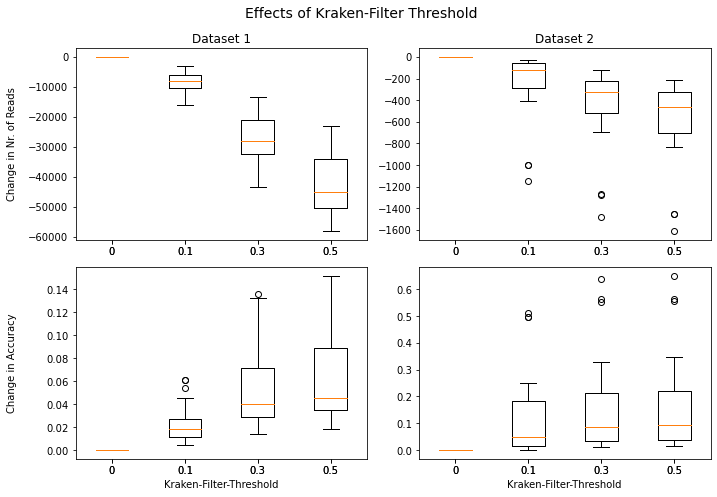

In [156]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((4, 4), (2, 0), colspan=2, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid((4, 4), (2, 2), colspan=2, rowspan=2, sharex=ax2)
# first, the Number of reads
## for dataset 1
data = []
krakenfilter = ["0", "0.1", "0.3", "0.5"]
for kf in krakenfilter:
    data.append((
        big_data_kmer[(big_data_kmer.Krakenfilter==kf)&(big_data_kmer.Dataset == '1')]["Diff"]));
ax1.boxplot(data);
ax1.set_title("Dataset 1")
ax1.set_ylabel("Change in Nr. of Reads")
ax1.get_yaxis().set_label_coords(-0.2,0.5)
#and for Dataset 2
data = []
for kf in ["0", "0.1", "0.3", "0.5"]:
    data.append((
        big_data_kmer[(big_data_kmer.Krakenfilter==kf)&(big_data_kmer.Dataset == '2')]["Diff"]));
ax2.boxplot(data);
ax2.set_title("Dataset 2")
# Second, the accuracys
## for dataset 1
data = []
for kf in ["0", "0.1", "0.3", "0.5"]:
    data.append((
        big_data_kmer[(big_data_kmer.Krakenfilter==kf)&(big_data_kmer.Dataset == '1')]["Diff_prop"]));
ax3.boxplot(data);
ax3.set_xticklabels(krakenfilter*2)
ax3.set_xlabel('Kraken-Filter-Threshold')
ax3.set_ylabel("Change in Accuracy")
ax3.get_yaxis().set_label_coords(-0.2,0.5)
#and for Dataset 2
data = []
for kf in ["0", "0.1", "0.3", "0.5"]:
    data.append((
        big_data_kmer[(big_data_kmer.Krakenfilter==kf)&(big_data_kmer.Dataset == '2')]["Diff_prop"]));
ax4.boxplot(data);
ax4.set_xticklabels(krakenfilter*2)
ax4.set_xlabel('Kraken-Filter-Threshold')

plt.suptitle("Effects of Kraken-Filter Threshold", fontsize=14)
plt.tight_layout()
plt.savefig("Kraken_threshold.png")
plt.show()

#### And the Baseline ####

In [169]:
baseline = big_data_kmer[(big_data_kmer.Krakenfilter=='0')&(big_data_kmer.Kmer != "MEGAN")]
baseline = baseline[['Dataset','Regime','Kmer','Extracted','Correct','Prop']]
baseline.to_csv("baseline.csv")

### And find the right Kmer ###

<ipython-input-192-6b43ffa69747>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(kmers*3)
<ipython-input-192-6b43ffa69747>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(kmers*3)


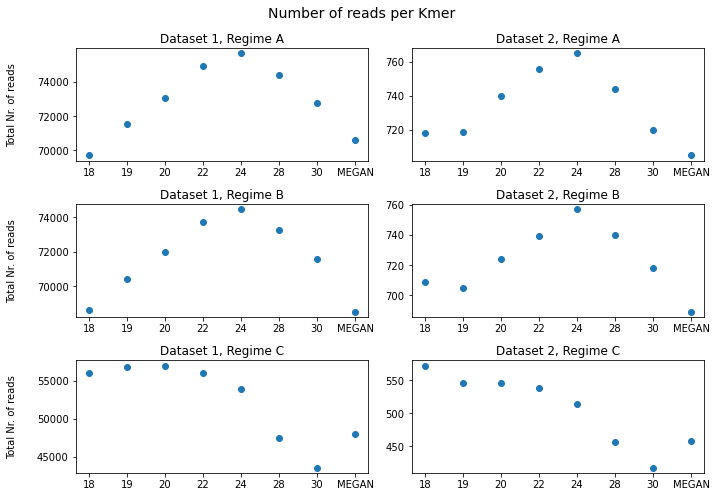

In [192]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 4), (2, 0), colspan=2, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid((6, 4), (2, 2), colspan=2, rowspan=2, sharex=ax2)
ax5 = plt.subplot2grid((6, 4), (4, 0), colspan=2, rowspan=2, sharex=ax1)
ax6 = plt.subplot2grid((6, 4), (4, 2), colspan=2, rowspan=2, sharex=ax2)
# first, the Number of reads
## for dataset 1
kmers = ["18","19","20","22","24","28","30","MEGAN"]

def get_data(ds, regime):
    data = []
    for kmer in kmers:
        if kmer != "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)&(big_data_kmer.Krakenfilter=="0.1")
                              &(big_data_kmer.Regime == regime)]["Extracted"])[0]
            )
        if kmer == "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)
                              &(big_data_kmer.Regime == regime)]["Extracted"])[0]
            )
    return data

ax1.scatter(kmers,get_data('1','A'));
ax1.set_title("Dataset 1, Regime A")
ax1.set_ylabel("Total Nr. of reads")
ax1.get_yaxis().set_label_coords(-0.2,0.5)

ax2.scatter(kmers,get_data('2','A'));
ax2.set_title("Dataset 2, Regime A")

ax3.scatter(kmers,get_data('1','B'));
ax3.set_title("Dataset 1, Regime B")
ax3.set_ylabel("Total Nr. of reads")
ax3.get_yaxis().set_label_coords(-0.2,0.5)

ax4.scatter(kmers,get_data('2','B'));
ax4.set_title("Dataset 2, Regime B")

ax5.scatter(kmers,get_data('1','C'));
ax5.set_xticklabels(kmers*3)
ax5.set_title("Dataset 1, Regime C")
ax5.set_ylabel("Total Nr. of reads")
ax5.get_yaxis().set_label_coords(-0.2,0.5)

ax6.scatter(kmers,get_data('2','C'));
ax6.set_xticklabels(kmers*3)
ax6.set_title("Dataset 2, Regime C")

plt.suptitle("Number of reads per Kmer", fontsize=14)
plt.tight_layout()
plt.savefig("Kmer_size.png")
plt.show()

<ipython-input-200-d55f1626c75d>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(kmers*3)
<ipython-input-200-d55f1626c75d>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(kmers*3)


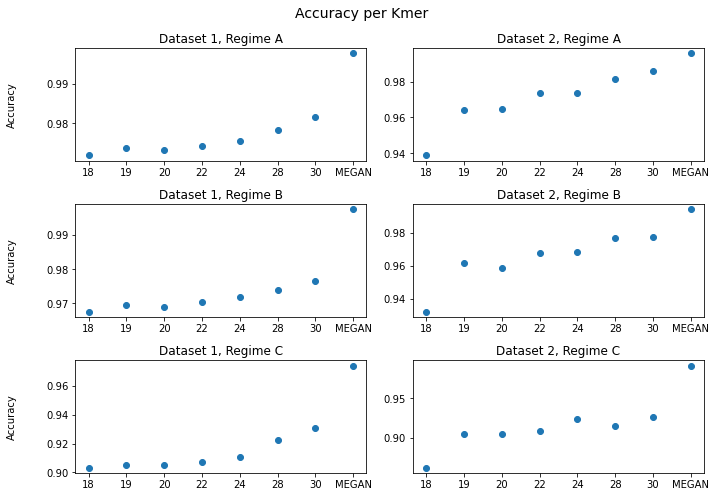

In [200]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 4), (2, 0), colspan=2, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid((6, 4), (2, 2), colspan=2, rowspan=2, sharex=ax2)
ax5 = plt.subplot2grid((6, 4), (4, 0), colspan=2, rowspan=2, sharex=ax1)
ax6 = plt.subplot2grid((6, 4), (4, 2), colspan=2, rowspan=2, sharex=ax2)
# first, the Number of reads
## for dataset 1
kmers = ["18","19","20","22","24","28","30","MEGAN"]

def get_data(ds, regime):
    data = []
    for kmer in kmers:
        if kmer != "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)&(big_data_kmer.Krakenfilter=="0.1")
                              &(big_data_kmer.Regime == regime)]["Prop"])[0]
            )
        if kmer == "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)
                              &(big_data_kmer.Regime == regime)]["Prop"])[0]
            )
    return data

ax1.scatter(kmers,get_data('1','A'));
ax1.set_title("Dataset 1, Regime A")
ax1.set_ylabel("Accuracy")
ax1.get_yaxis().set_label_coords(-0.2,0.5)

ax2.scatter(kmers,get_data('2','A'));
ax2.set_title("Dataset 2, Regime A")

ax3.scatter(kmers,get_data('1','B'));
ax3.set_title("Dataset 1, Regime B")
ax3.set_ylabel("Accuracy")
ax3.get_yaxis().set_label_coords(-0.2,0.5)

ax4.scatter(kmers,get_data('2','B'));
ax4.set_title("Dataset 2, Regime B")

ax5.scatter(kmers,get_data('1','C'));
ax5.set_xticklabels(kmers*3)
ax5.set_title("Dataset 1, Regime C")
ax5.set_ylabel("Accuracy")
ax5.get_yaxis().set_label_coords(-0.2,0.5)

ax6.scatter(kmers,get_data('2','C'));
ax6.set_xticklabels(kmers*3)
ax6.set_title("Dataset 2, Regime C")

plt.suptitle("Accuracy per Kmer", fontsize=14)
plt.tight_layout()
plt.savefig("Kmer_size_accuracy.png")
plt.show()

<ipython-input-195-4c685920840d>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(kmers*3)
<ipython-input-195-4c685920840d>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(kmers*3)


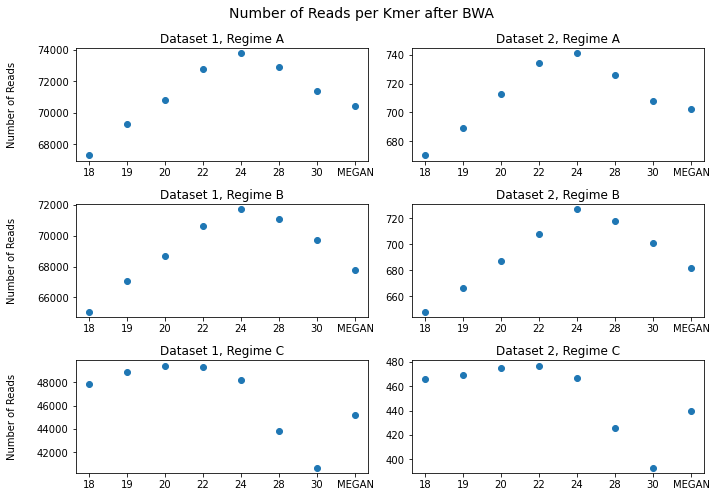

In [195]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 4), (2, 0), colspan=2, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid((6, 4), (2, 2), colspan=2, rowspan=2, sharex=ax2)
ax5 = plt.subplot2grid((6, 4), (4, 0), colspan=2, rowspan=2, sharex=ax1)
ax6 = plt.subplot2grid((6, 4), (4, 2), colspan=2, rowspan=2, sharex=ax2)
# first, the Number of reads
## for dataset 1
kmers = ["18","19","20","22","24","28","30","MEGAN"]

def get_data(ds, regime):
    data = []
    for kmer in kmers:
        if kmer != "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)&(big_data_kmer.Krakenfilter=="0.1")
                              &(big_data_kmer.Regime == regime)]["Aligned"])[0]
            )
        if kmer == "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)
                              &(big_data_kmer.Regime == regime)]["Aligned"])[0]
            )
    return data

ax1.scatter(kmers,get_data('1','A'));
ax1.set_title("Dataset 1, Regime A")
ax1.set_ylabel("Number of Reads")
ax1.get_yaxis().set_label_coords(-0.2,0.5)

ax2.scatter(kmers,get_data('2','A'));
ax2.set_title("Dataset 2, Regime A")

ax3.scatter(kmers,get_data('1','B'));
ax3.set_title("Dataset 1, Regime B")
ax3.set_ylabel("Number of Reads")
ax3.get_yaxis().set_label_coords(-0.2,0.5)

ax4.scatter(kmers,get_data('2','B'));
ax4.set_title("Dataset 2, Regime B")

ax5.scatter(kmers,get_data('1','C'));
ax5.set_xticklabels(kmers*3)
ax5.set_title("Dataset 1, Regime C")
ax5.set_ylabel("Number of Reads")
ax5.get_yaxis().set_label_coords(-0.2,0.5)

ax6.scatter(kmers,get_data('2','C'));
ax6.set_xticklabels(kmers*3)
ax6.set_title("Dataset 2, Regime C")

plt.suptitle("Number of Reads per Kmer after BWA", fontsize=14)
plt.tight_layout()
plt.savefig("Kmer_size_after_BWA.png")
plt.show()

### Kmer Sizes after BWA? ###

<ipython-input-199-c46e0e9822fb>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(kmers*3)
<ipython-input-199-c46e0e9822fb>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(kmers*3)


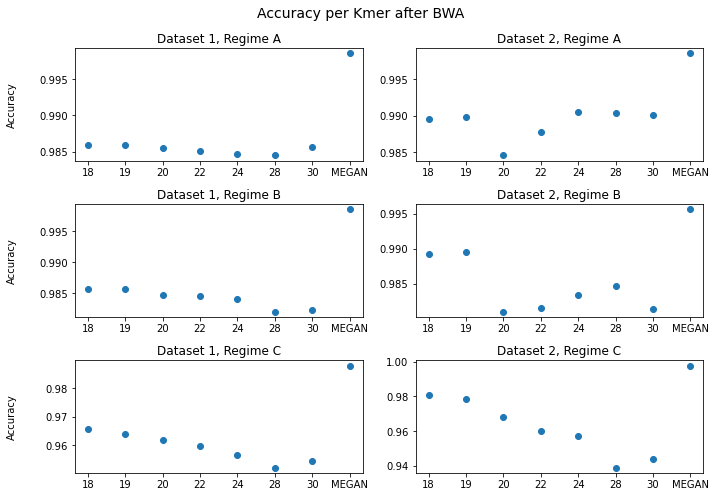

In [199]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 4), (2, 0), colspan=2, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid((6, 4), (2, 2), colspan=2, rowspan=2, sharex=ax2)
ax5 = plt.subplot2grid((6, 4), (4, 0), colspan=2, rowspan=2, sharex=ax1)
ax6 = plt.subplot2grid((6, 4), (4, 2), colspan=2, rowspan=2, sharex=ax2)
# first, the Number of reads
## for dataset 1
kmers = ["18","19","20","22","24","28","30","MEGAN"]

def get_data(ds, regime):
    data = []
    for kmer in kmers:
        if kmer != "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)&(big_data_kmer.Krakenfilter=="0.1")
                              &(big_data_kmer.Regime == regime)]["Prop_alig"])[0]
            )
        if kmer == "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)
                              &(big_data_kmer.Regime == regime)]["Prop_alig"])[0]
            )
    return data

ax1.scatter(kmers,get_data('1','A'));
ax1.set_title("Dataset 1, Regime A")
ax1.set_ylabel("Accuracy")
ax1.get_yaxis().set_label_coords(-0.2,0.5)

ax2.scatter(kmers,get_data('2','A'));
ax2.set_title("Dataset 2, Regime A")

ax3.scatter(kmers,get_data('1','B'));
ax3.set_title("Dataset 1, Regime B")
ax3.set_ylabel("Accuracy")
ax3.get_yaxis().set_label_coords(-0.2,0.5)

ax4.scatter(kmers,get_data('2','B'));
ax4.set_title("Dataset 2, Regime B")

ax5.scatter(kmers,get_data('1','C'));
ax5.set_xticklabels(kmers*3)
ax5.set_title("Dataset 1, Regime C")
ax5.set_ylabel("Accuracy")
ax5.get_yaxis().set_label_coords(-0.2,0.5)

ax6.scatter(kmers,get_data('2','C'));
ax6.set_xticklabels(kmers*3)
ax6.set_title("Dataset 2, Regime C")

plt.suptitle("Accuracy per Kmer after BWA", fontsize=14)
plt.tight_layout()
plt.savefig("Kmer_size_accuracy_afterbwa.png")
plt.show()

<ipython-input-202-d0453ea369c9>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(kmers*3)
<ipython-input-202-d0453ea369c9>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax6.set_xticklabels(kmers*3)


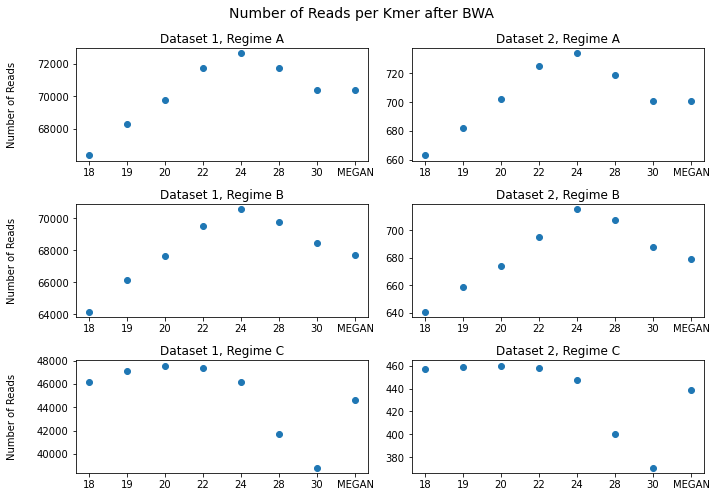

In [202]:
fig = plt.figure(figsize=(10,7))
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 4), (2, 0), colspan=2, rowspan=2, sharex=ax1)
ax4 = plt.subplot2grid((6, 4), (2, 2), colspan=2, rowspan=2, sharex=ax2)
ax5 = plt.subplot2grid((6, 4), (4, 0), colspan=2, rowspan=2, sharex=ax1)
ax6 = plt.subplot2grid((6, 4), (4, 2), colspan=2, rowspan=2, sharex=ax2)
# first, the Number of reads
## for dataset 1
kmers = ["18","19","20","22","24","28","30","MEGAN"]

def get_data(ds, regime):
    data = []
    for kmer in kmers:
        if kmer != "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)&(big_data_kmer.Krakenfilter=="0.1")
                              &(big_data_kmer.Regime == regime)]["Aligned_Correct"])[0]
            )
        if kmer == "MEGAN":
            data.append(
                list(big_data_kmer[(big_data_kmer.Kmer==kmer)&(big_data_kmer.Dataset == ds)
                              &(big_data_kmer.Regime == regime)]["Aligned_Correct"])[0]
            )
    return data

ax1.scatter(kmers,get_data('1','A'));
ax1.set_title("Dataset 1, Regime A")
ax1.set_ylabel("Number of Reads")
ax1.get_yaxis().set_label_coords(-0.2,0.5)

ax2.scatter(kmers,get_data('2','A'));
ax2.set_title("Dataset 2, Regime A")

ax3.scatter(kmers,get_data('1','B'));
ax3.set_title("Dataset 1, Regime B")
ax3.set_ylabel("Number of Reads")
ax3.get_yaxis().set_label_coords(-0.2,0.5)

ax4.scatter(kmers,get_data('2','B'));
ax4.set_title("Dataset 2, Regime B")

ax5.scatter(kmers,get_data('1','C'));
ax5.set_xticklabels(kmers*3)
ax5.set_title("Dataset 1, Regime C")
ax5.set_ylabel("Number of Reads")
ax5.get_yaxis().set_label_coords(-0.2,0.5)

ax6.scatter(kmers,get_data('2','C'));
ax6.set_xticklabels(kmers*3)
ax6.set_title("Dataset 2, Regime C")

plt.suptitle("Number of Reads per Kmer after BWA", fontsize=14)
plt.tight_layout()
plt.savefig("Kmer_size_after_BWA_correct.png")
plt.show()

## Additional Filters ##

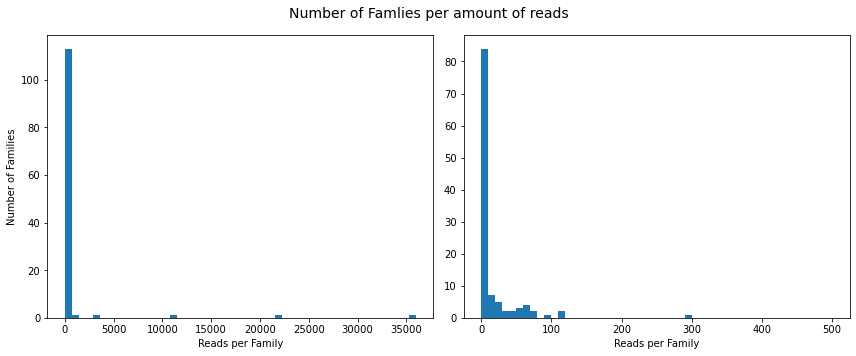

In [227]:
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2)
data = list(big_data[(big_data.Dataset == '1')&(big_data.Regime =='A')&
         (big_data.Kmer=='22')&(big_data.Krakenfilter=="0.1")
        ].groupby(['Assigned_Fam'], as_index=False).sum()['Extracted'])

ax1.hist(data, bins=50)
ax1.set_ylabel("Number of Families")
ax1.set_xlabel("Reads per Family")
ax2.hist(data,range=(0,500), bins=50 )
ax2.set_xlabel("Reads per Family")
plt.suptitle("Number of Famlies per amount of reads", fontsize=14)
plt.tight_layout()
plt.savefig("Histogram_reads_per_fam.png")